# 1.分析get请求数据以及post请求数据
get得到的json数据可以通过base64解码出两张图片:图片背景图以及插图。

id信息会在post中"yzm"字段用到

程序一为还原图片，程序二为叠放图片。

In [1]:
import base64
import json
import time
import requests
import joblib
""" 

"""
# url = "http://202.117.17.144:8080/gen"
# r = requests.get(url)
# response_json = r.json()
with open("request/get.json") as f:
    response_json = json.load(f)
start_idx = len("data:image/jpeg;base64,")
backgroundImage = response_json["captcha"]["backgroundImage"][start_idx:]
bgImg = base64.b64decode(backgroundImage)
str = time.asctime()
with open("bgImg.png",'wb') as f:
    f.write(bgImg)
start_idx = len("data:image/png;base64,")
sliderImage = response_json["captcha"]["sliderImage"][start_idx:]
sldImg = base64.b64decode(sliderImage)
with open("resource/sliderImg.png",'wb') as f:
    f.write(sldImg)

# joblib.dump(r, 'x.pkl') 

In [3]:
import cv2
import numpy as np
# 加载图像
img1 = cv2.imread('resource/sliderImg.png')
img2 = cv2.imread('resource/bgImg.png')
pad_w = img2.shape[1] - img1.shape[1] # 计算需要填充的像素数目（图像的宽这一维度上）
img1_new = cv2.copyMakeBorder(img1,0,0,0,pad_w,cv2.BORDER_CONSTANT,None,(0,0,0))
res = cv2.add(img1_new,img2)

cv2.imwrite("concat_img.png",res)
cv2.imshow('imshow',res)
cv2.waitKey(0)
cv2.destroyAllWindows()

True

接下来研究post.json中的内容：startSlidingTime、endSlidingTime、tracklist

以下代码可根据post中发送的参数还原出track的动画效果

In [ ]:
import datetime
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
with open("request/post.json") as f:
    track = json.load(f)

_start_slide_time = track["startSlidingTime"]
_end_slide_time = track["endSlidingTime"]
start_slide_time = datetime.datetime.strptime(_start_slide_time, '%Y-%m-%dT%H:%M:%S.%fZ')
end_slide_time = datetime.datetime.strptime(_end_slide_time, '%Y-%m-%dT%H:%M:%S.%fZ')
t = end_slide_time -start_slide_time 
microseconds = int(t.seconds*1000 + t.microseconds//1000 + 1) 
fig = plt.figure()
plt.xlim(0,200)
plt.ylim(-100,100)


ims = []
tracklist = track["trackList"]
i = 0
xlist = []
ylist = []
im = []
data_time = int(tracklist[i]["t"])
    
for gif_time in range(0,microseconds,20):
    if data_time < gif_time:
        x,y = tracklist[i]["x"],tracklist[i]["y"]
        xlist.append(x)
        ylist.append(y)
        im = plt.plot(xlist,ylist,color="black")
        while data_time <= gif_time and i < len(tracklist):
            i += 1
            data_time = int(tracklist[i]["t"])
    ims.append(im)
# plt.show()

ani = animation.ArtistAnimation(fig, ims, interval=20, repeat_delay=1000)
ani.save("resource/test.gif", writer='pillow')
    

x y已经研究清楚了，t的变化是怎样的

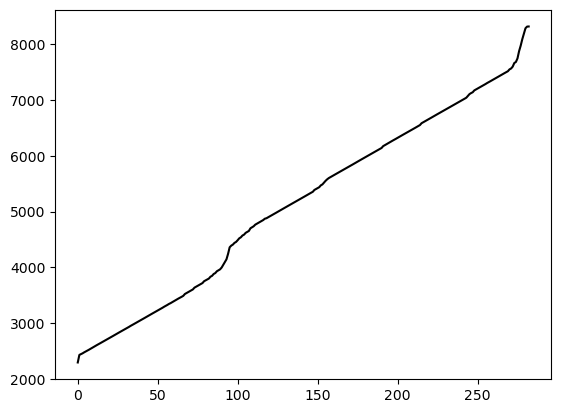

In [4]:
import matplotlib.pyplot as plt
with open("request/post.json") as f:
    track = json.load(f)
t= [item["t"] for item in track["trackList"]] 
plt.plot(t,color="black") 

可以用 t = k*n 近似这种规律

according preliminary exercise, we can draw below conclusions.
-  track 中的原点是手指最早触碰屏幕的点 (0，0)
-  总时间是 startSlidingTime - endSlidingTime, tracklist 第三个参数是毫秒
-  tracklist中type第一个为down，中间为move，最后一个为up
-  分析部分已完成，接下来需要cv对缺口的位置识别，识别精度要高


In [ ]:
import cv2
def identify_gap(bg,tp,out="identify.png"):
    '''
    bg: 背景图片
    tp: 缺口图片
    out:输出图片
    '''
    # 读取背景图片和缺口图片
    bg_img = cv2.imread(bg)
    tp_img = cv2.imread(tp)
    
    # 识别图片边缘
    bg_edge = cv2.Canny(bg_img, 100, 200)
    tp_edge = cv2.Canny(tp_img, 100, 200)
    
    # 转换图片格式
    bg_pic = cv2.cvtColor(bg_edge, cv2.COLOR_GRAY2RGB)
    tp_pic = cv2.cvtColor(tp_edge, cv2.COLOR_GRAY2RGB)
    
    # 缺口匹配
    res = cv2.matchTemplate(bg_pic, tp_pic, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res) # 寻找最优匹配
    
    # 绘制方框
    th, tw = tp_pic.shape[:2] 
    tl = max_loc # 左上角点的坐标
    br = (tl[0]+tw,tl[1]+th) # 右下角点的坐标
    cv2.rectangle(bg_img, tl, br, (0, 0, 255), 2) # 绘制矩形
    cv2.imwrite(out, bg_img) # 保存在本地
    
    # 返回缺口的X坐标
    return tl[0]+tw//2
print(identify_gap('resource/bgImg.png','resource/sliderImg.png'))

几个重要参数
- bgimg (590,360)
- sliderImg (110,360)
- 缺口 (374,275)

因此该问题已经十分明了。

发送参数"bgImageWidth":260,"bgImageHeight":0,"sliderImageWidth":0,"sliderImageHeight":159

(260,159)为屏幕显示时图片大小，与(590,360)等比

理想移动距离：374-110/2 = 319 按照590:260的比例缩放，即得到实际移动距离140
在实际操作中，tracklist中"x":139，与理论计算一致

把以上分析整合为API, [slider_yzm.py](./slider_yzm.py)